<a href="https://colab.research.google.com/github/Terkinsss/karpov_courses_intermediate_project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Промежуточный проект 1й варинт

Студент Федотов Илья

Старт потока 23.03.2023

# Проект e-commerce


Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти [тут](https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz). (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти [тут](https://guillaume-martin.github.io/rfm-segmentation-with-python.html). (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

**Файлы:**

[olist_customers_datase.csv](https://disk.yandex.ru/d/QXrVDUoQvFhIcg)— таблица с уникальными идентификаторами пользователей
* *customer_id* — позаказный идентификатор пользователя

* *customer_unique_id* —  уникальный идентификатор пользователя  (аналог номера паспорта)

* *customer_zip_code_prefix* —  почтовый индекс пользователя

* *customer_city* —  город доставки пользователя

* *customer_state* —  штат доставки пользователя

[olist_orders_dataset.csv](https://disk.yandex.ru/d/0zWmh1bYP6REbw) —  таблица заказов
* *order_id* —  уникальный идентификатор заказа (номер чека)

* *customer_id* —  позаказный идентификатор пользователя

* *order_status* —  статус заказа

* *order_purchase_timestamp* —  время создания заказа

* *order_approved_at* —  время подтверждения оплаты заказа

* *order_delivered_carrier_date* —  время передачи заказа в логистическую службу

* *order_delivered_customer_date* —  время доставки заказа

* *order_estimated_delivery_date* —  обещанная дата доставки

[olist_order_items_dataset.csv](https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg) —  товарные позиции, входящие в заказы
* *order_id* —  уникальный идентификатор заказа (номер чека)

* *order_item_id* —  идентификатор товара внутри одного заказа

* *product_id* —  ид товара (аналог штрихкода)

* *seller_id* — ид производителя товара

* *shipping_limit_date* —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

* *price* —  цена за единицу товара

* *freight_value* —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён

In [248]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

plt.rcParams["figure.figsize"] = (10,5)

In [249]:
# начнем с выгрузки датасетов с яндекс диска.

olist_customers_datase = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
olist_orders_dataset = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
olist_order_items_dataset = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [250]:
# воспользуемся api ЯндексДиска для выгрузки датасетов

def get_ydisk_url(public_key: str) -> str:
  """Returns url from YandexDisc api"""
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=public_key))
  response = requests.get(final_url)
  download_url = response.json()['href']
  return download_url

In [251]:
# сохраним датасеты в переменные

customers = pd.read_csv(get_ydisk_url(olist_customers_datase))
orders = pd.read_csv(get_ydisk_url(olist_orders_dataset))
items = pd.read_csv(get_ydisk_url(olist_order_items_dataset))

## EDA
**Для начала проведем разведовательный анализ и посмотрим на наши данные в разных датасетах.**

Взглянем на датасет с пользователями.

In [252]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [253]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [254]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [255]:
customers.duplicated().sum()

0

Взглянем на данные по заказам.

In [256]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [257]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [258]:
# мы видим что колонки с датами имеют тип object, для работы нам удобнее 
# изменить формат на datetime

date_columns_orders = ['order_purchase_timestamp',
                       'order_approved_at', 
                       'order_delivered_carrier_date', 
                       'order_delivered_customer_date', 
                       'order_estimated_delivery_date']
orders[date_columns_orders] = orders[date_columns_orders].apply(pd.to_datetime)

In [259]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [260]:
# посчитаем пропущенные значения

orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [261]:
orders.duplicated().sum()

0

Перейдем к датафрейму с товарными позициями.

In [262]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [263]:
items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [264]:
# тоже изменим тип данных в колонке с датой на datetime

items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'])

In [265]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [266]:
items.duplicated().sum()

0

## Задание 1

**Сколько у нас пользователей, которые совершили покупку только один раз?**

Нам нужно понять каких пользователей мы будем считать совершившими покупку. В датафрейме orders есть колонка "order_approved_at" - наличие в ней записей и будем считать успешной покупкой. Так же посмотрим на колонку "order_status".

In [267]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Мы видим что в колонке "order_status" есть значения с отмененными и недоступными заказами, их мы учитывать тоже не будем.

In [268]:
success_orders = orders.query("order_status not in ('canceled', 'unavailable') \
and order_approved_at.notna()")
success_orders.shape

(98188, 8)

Чтобы найти уникальных пользователей нам нужно соеденить таблицу с заказами и таблицу с покупателями.

In [269]:
orders_merged = success_orders.merge(customers, on='customer_id')

In [270]:
orders_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


Сгрупируем по уникальным пользователям и посчитаем число заказов.

In [271]:
num_of_orders = orders_merged.groupby('customer_unique_id')['order_id'].count()

In [272]:
print(f'Колличество пользователей совершивших 1 покупку: \
{num_of_orders[num_of_orders == 1].count()}')

Колличество пользователей совершивших 1 покупку: 92087


## Задание 2

**Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

В этом задании нам тоже предстоит определить что считать доставлеными заказами а что нет. В колонке `order_status` есть такие статусы заказов как отменен и недоступен (`canceled`, `unavailable`). Эти статусы должны нам подходить. Проверим есть ли строки в таблице где в колонке `order_delivered_customer_date` есть дата доставки, а статус заказа `canceled` или `unavailable`.


In [273]:
refund_orders = orders.query("order_delivered_customer_date.notna() \
                and order_status in ('canceled', 'unavailable')")
refund_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


Мы нашли 6 строчек со статусом заказа `canceled` и проставленной датой доставки до покупателя. Можно предположить что это возвраты товара. Такие товары мы будем считать так же доставленными.

Проверим ошибки в статусах заказов.



In [274]:
mistake_orders = orders.query("order_delivered_customer_date.isna() \
                 and order_status == 'delivered'")
mistake_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Тут мы обнаружили несколько строк где статуст заказа `delivered` а даты доставки клиенту нет. Такие данные будем считать ошибочными.

Получается 3 причины по которым заказы не доставляются:
1.   Заказ отменен (не учитывая возвраты)
2.   Заказ недоступен
3.   Ошибки в данных

Для удобства создадим колонку с месяцем создания заказа.






In [275]:
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

1. Отберем данные со статусом `canceled` не учитывая возвраты.

In [276]:
refund_orders_list = refund_orders['order_id'].to_list()


In [277]:
canceled_orders = orders.query("order_status == 'canceled' \
                  and order_id not in @refund_orders_list") \
                  .groupby('order_month', as_index=False) \
                  .agg({'order_id': 'count'}) \
                  .rename(columns={'order_id': 'canceled_ord_amount'}) \

canceled_orders.head()

,order_month,canceled_ord_amount
0,2016-09-01,2
1,2016-10-01,19
2,2017-01-01,3
3,2017-02-01,17
4,2017-03-01,33


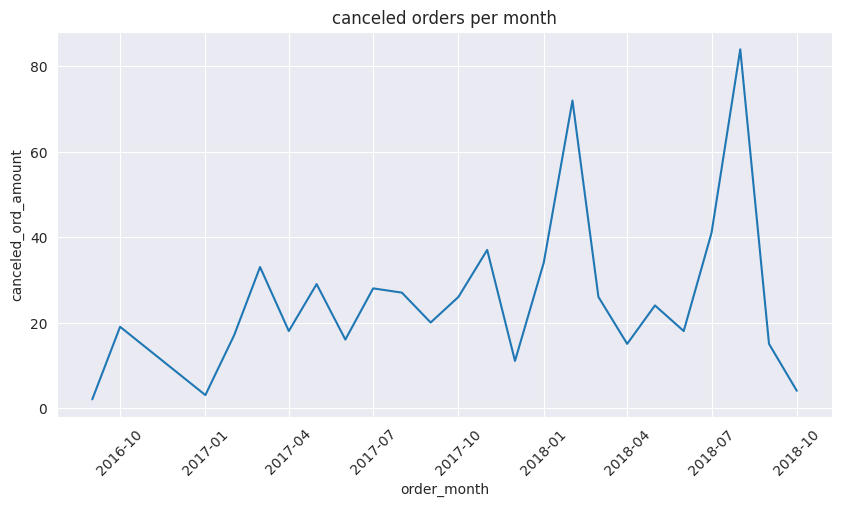

In [278]:
plt.xticks(rotation=45)
sns.set_style('darkgrid')
sns.lineplot(data=canceled_orders, x='order_month', y='canceled_ord_amount') \
.set(title='canceled orders per month');

2. Отберем заказы со статусом `unavailable`.

In [279]:
unavailable_orders = orders.query("order_status == 'unavailable'") \
                  .groupby('order_month', as_index=False) \
                  .agg({'order_id': 'count'}) \
                  .rename(columns={'order_id': 'unavailable_ord_amount'}) \

unavailable_orders.head()

,order_month,unavailable_ord_amount
0,2016-10-01,7
1,2017-01-01,10
2,2017-02-01,45
3,2017-03-01,32
4,2017-04-01,9


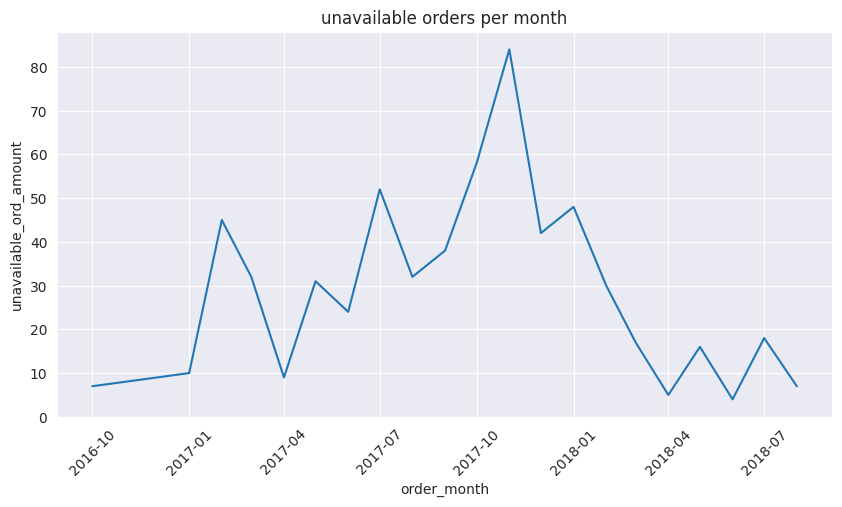

In [280]:
plt.xticks(rotation=45)
sns.set_style('darkgrid')
sns.lineplot(data=unavailable_orders, x='order_month',\
             y='unavailable_ord_amount') \
             .set(title='unavailable orders per month');

3. Заказы с ошибками.

In [281]:
mistake_orders = orders.query("order_delivered_customer_date.isna() \
                 and order_status == 'delivered'") \
                  .groupby('order_month', as_index=False) \
                  .agg({'order_id': 'count'}) \
                  .rename(columns={'order_id': 'mistake_ord_amount'})

mistake_orders


,order_month,mistake_ord_amount
0,2017-05-01,1
1,2017-11-01,1
2,2018-06-01,3
3,2018-07-01,3


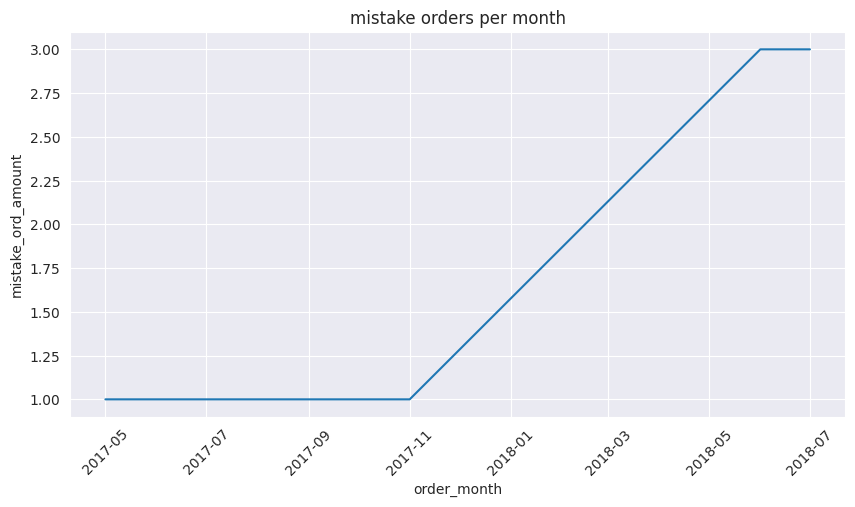

In [282]:
plt.xticks(rotation=45)
sns.set_style('darkgrid')
sns.lineplot(data=mistake_orders, x='order_month',\
             y='mistake_ord_amount') \
             .set(title='mistake orders per month');

In [283]:
print(f"Среднее колличество отмененных заказов в месяц: \
{canceled_orders['canceled_ord_amount'].mean().round(2)}")
print(f"Среднее колличество недоступных заказов в месяц: \
{unavailable_orders['unavailable_ord_amount'].mean().round(2)}")
print(f"Среднее колличество ошибочных заказов в месяц: \
{mistake_orders['mistake_ord_amount'].mean().round(2)}")

Среднее колличество отмененных заказов в месяц: 25.79
Среднее колличество недоступных заказов в месяц: 29.0
Среднее колличество ошибочных заказов в месяц: 2.0


## Задание 3

**По каждому товару определить, в какой день недели товар чаще всего покупается.**

Для начала соеденим таблицу с товарными позициями с таблицей с заказами.

In [284]:
orders_items = items.merge(orders, on='order_id', how='left')
orders_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09-01
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04-01
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08-01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02-01


Добавим колонку с днями недели и сагрегируем данные по id продукта. Будем использовать моду, чтобы учесть те дни, когда товар продавался одинаково хорошо.

In [285]:
orders_items['weekday'] = orders_items['order_purchase_timestamp'].dt.day_name()

In [286]:
product_amount = orders_items.groupby('product_id', as_index=False) \
              .agg({'weekday': pd.Series.mode})

product_amount.head()

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


## Задание 4

**Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

Для начала воспользуемся таблицей из 1 задания, где отобраны пользователи совершившие покупку.

In [287]:
orders_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


В этом задании нам нужно будет посчитать количество недель в месяце, это можно сделать поделив количество дней в месяце на 7. Так же посчитать количество покупок за месяц и разделить на количество недель.

Для начала нужно посмотреть начало и конец периода когда совершались покупки, чтобы учесть это в подсчете количества недель.

In [288]:
print(orders_merged['order_purchase_timestamp'].min(),
      orders_merged['order_purchase_timestamp'].max(),sep='\n\n')

2016-09-04 21:15:19

2018-09-03 09:06:57


Мы видим что в сентябре 2016 у нас есть данные только с 4 числа, а в  2018 до 3 сентября. 

Напишем функцию которая подсчитывает количество недель в месяце, учитывая начало и конец периода наших данных.

In [289]:
def weeks_in_month(date):
  '''Returns number of weeks in month from timestamp'''
  min_date = date.min()
  max_date = date.max()
  result = []
  for dt in date:
    if dt.year == min_date.year and dt.month == min_date.month:
      transform_dt = dt.days_in_month - min_date.day
    elif dt.year == max_date.year and dt.month == max_date.month:
      transform_dt = max_date.day
    else:
      transform_dt = dt.days_in_month
    result.append(transform_dt)
  return np.array(result) / 7

In [290]:
orders_merged['weeks_in_month'] = weeks_in_month(
          orders_merged['order_purchase_timestamp'])

Проверим что функция сработала нормально.

In [291]:
orders_merged['weeks_in_month'].value_counts()

4.428571    59561
4.285714    30294
4.000000     8330
3.714286        2
0.428571        1
Name: weeks_in_month, dtype: int64

Агрегируем данные чтобы найти количество заказов.

In [297]:
num_of_orders = orders_merged \
            .groupby(['customer_unique_id', 'weeks_in_month'], as_index=False)\
            .agg({'order_id': 'count'}) \
            .rename(columns={'order_id': 'num_of_orders'})
num_of_orders.head()

,customer_unique_id,weeks_in_month,num_of_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.428571,1
2,0000f46a3911fa3c0805444483337064,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,4.285714,1


Теперь разделим количество покупок на количество недель в месяце.

In [303]:
num_of_orders['orders_per_month'] = num_of_orders['num_of_orders'] \
                                  / num_of_orders['weeks_in_month']

num_of_orders.sort_values('orders_per_month', ascending=False).head()

,customer_unique_id,weeks_in_month,num_of_orders,orders_per_month
52920,8d50f5eadf50201ccdcedfb9e2ac8455,4.428571,13,2.935484
95705,ff22e30958c13ffe219db7d711e8f564,0.428571,1,2.333333
7167,12f5d6e1cbf93dafd9dcc19095df0b3d,4.428571,6,1.354839
67957,b4e4f24de1e8725b74e4a1f4975116ed,4.000000,4,1.000000
23446,3e43e6105506432c953e165fb2acf44c,4.000000,4,1.000000
